In [1]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [6]:
with tf.device('/gpu:1'):
    x = tf.placeholder(tf.float32, shape=(None, 20, 64))
    y = LSTM(32)(x)  

In [2]:
train_path = 'data/baidu/image_contest_level_2_processed/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [3]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    for c in range(cnt):
        label_exp_files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))

In [4]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))
    for exp in exprs.split(';'):
        exp_labels.append(exp.decode('utf8'))
        exp_lens.append(len(exp.decode('utf8')))

In [5]:
short_idxs = []
long_idxs = []
cursor = 0
for cnt in label_exp_count:
    for i in range(cnt):
        if i==cnt-1:
            long_idxs.append(cursor+i)
        else: 
            short_idxs.append(cursor+i)
    cursor = cursor + cnt
short_idxs = np.asarray(short_idxs)
long_idxs = np.asarray(long_idxs)

In [6]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, idxs, width, height):
        self.width = width
        self.height = height
        self.idxs = idxs
        self.label_length = max(np.asarray(exp_lens)[self.idxs])

        #mask = np.random.rand(len(self.idxs)) < 0.9
        #self.trn_idxs = self.idxs[mask]
        #self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels)[self.idxs]:
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            yield self.fetch_img_by_idxs(out), np.asarray(self.actual_labels)[out]
        
    def fetch_img_by_idxs(self, idxs):
        imgs = []
        for f in np.array(label_exp_files)[idxs]:
            img = cv2.imread(train_path+f)
            img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
            img = np.transpose(np.asarray(img), (1, 0, 2))
            imgs.append(img)
        return np.array(imgs)
    
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

In [7]:
### 决定使用什么类型的数据
using_idxs = long_idxs
img_label_data_prefix = 'all_long'
data_path = 'data/baidu/all-long-300-45/'

img_w = 300
img_h = 45

img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)

In [8]:
def save_raw_data():
    da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
    imgs, labels = next(da)
    save_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix),  imgs)
    save_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix), labels)

def load_raw_data():
    imgs = load_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix))
    labels = load_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix))
    return (imgs, labels)
    
def save_split_data(x_trn, y_trn, x_val, y_val):

    save_array(data_path+"x_trn", x_trn)
    save_array(data_path+"y_trn", y_trn)


    save_array(data_path+"x_val", x_val)
    save_array(data_path+"y_val", y_val)

def load_split_data():

    x_trn = load_array(data_path+"x_trn")
    y_trn = load_array(data_path+"y_trn")

    x_val = load_array(data_path+"x_val")
    y_val = load_array(data_path+"y_val")
    
    return (x_trn, y_trn, x_val, y_val)

In [9]:
#save_raw_data()
imgs, labels = load_raw_data()

In [123]:
mask = np.random.rand(len(using_idxs)) < 0.9
idxs = np.random.permutation(len(using_idxs))
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]

da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
imgs, labels = next(da)

x_trn = imgs[trn_idxs]
y_trn = labels[trn_idxs]

x_val = imgs[val_idxs]
y_val = labels[val_idxs]

In [10]:
#save_split_data(x_trn, y_trn, x_val, y_val)
x_trn, y_trn, x_val, y_val = load_split_data()

In [11]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((90103, 300, 45, 3), (90103, 30), (9897, 300, 45, 3), (9897, 30))

In [12]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [13]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [14]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [15]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [16]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [18]:
batch_size = 128
da = image.ImageDataGenerator()
x_trn_len = len(x_trn)//batch_size*batch_size
trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)

In [17]:
def trn_gen():
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + 71
    while True:
        x, y = next(trn_batches)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x, y, input_length, label_length], np.zeros([batch_size])

In [19]:
def val_data():
    size = len(x_val)
    input_length = np.zeros([size, 1]) + 71
    label_length = gen_label_length(y_val)
    return [x_val, y_val, input_length, label_length], np.zeros([size])

In [24]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

(300, 45, 3)
[ 7 10  7  8  4  0 40  2 15  8 12 14 13  4 33  5  7 15  8 12 10  1  0  0  0  0  0  0  0  0]
1412-(锁*92687-流/19264)((((((((
[ 71.]
[22]


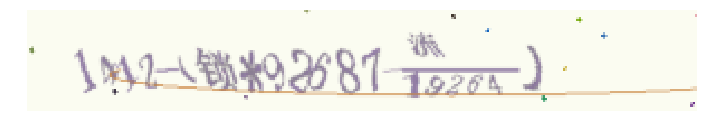

In [25]:
inspect_trn_data()

In [20]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [21]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    correct_long_n = 0
    total_long_n = 0
    correct_short_n = 0
    total_short_n = 0
    
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        if img_gen.label_length - len(l) < 0:
            print(l)
        pred = np.lib.pad(l, ((0, abs(img_gen.label_length - len(l)))),  mode='constant', constant_values=0)
        equal = np.array_equal(pred, y_test[j])
        is_long = is_long_label(y_test[j])
        if is_long:
            total_long_n=total_long_n+1
        else:
            total_short_n=total_short_n+1
        if equal:
            correct_number = correct_number+1
            if is_long:
                correct_long_n=correct_long_n+1
            else:
                correct_short_n=correct_short_n+1
    l = 0
    s = 0
    if total_long_n>0: l=correct_long_n/total_long_n
    if total_short_n>0: s=correct_short_n/total_short_n
    
    return correct_number/batch_num, s, l

In [ ]:
def evaluate2(model, batch_num=10):
    
    [X_test, y_test, _, _], _  = val_data()
    y_pred = base_model.predict(X_test)
    shape = y_pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
    if out.shape[1] == 4:
        batch_acc += ((y_test == out).sum(axis=1) == 4).mean()


In [77]:
[X_test, y_test, _, _], _  = val_data()
pred = base_model.predict(X_test[:10000])
shape = pred[:,2:,:].shape
out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

In [76]:
out.shape

(9968, 36)

In [41]:
K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])

InvalidArgumentError: No OpKernel was registered to support Op 'Inv' with these attrs.  Registered kernels:
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_FLOAT]

	 [[Node: moments_20/normalize/divisor = Inv[T=DT_INT32](moments_20/sufficient_statistics/Prod, ^moments_20/sufficient_statistics/mean_ss, ^moments_20/sufficient_statistics/var_ss)]]

Caused by op u'moments_20/normalize/divisor', defined at:
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-3c89d2fb1285>", line 4, in <module>
    inner = BatchNormalization()(input_data)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/normalization.py", line 120, in call
    epsilon=self.epsilon)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 1394, in normalize_batch_in_training
    shift=None, name=None, keep_dims=False)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn.py", line 836, in moments
    mean, variance = normalize_moments(counts, m_ss, v_ss, shift, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn.py", line 787, in normalize_moments
    divisor = math_ops.inv(counts, name="divisor")
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1075, in inv
    result = _op_def_lib.apply_op("Inv", x=x, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'Inv' with these attrs.  Registered kernels:
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_FLOAT]

	 [[Node: moments_20/normalize/divisor = Inv[T=DT_INT32](moments_20/sufficient_statistics/Prod, ^moments_20/sufficient_statistics/mean_ss, ^moments_20/sufficient_statistics/var_ss)]]


In [48]:
(np.ones(shape[0])*shape[1])[0]

68.0

In [68]:
out_best = np.array([1,2])
l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
np.lib.pad(l, ((0, img_gen.label_length - len(l))),  mode='constant', constant_values=0)

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc, s, l = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        s = s * 100
        l = l * 100
        print(' acc: {}% long: {}% short: {}%'.format(acc, s, l))
        
        if acc > 95:
            model.save_weights('v{}.wgt'.format(epoch))

evaluator = Evaluate()

In [28]:
ctc_time_lenght = 75
input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
x = MaxPooling2D()(inner)


inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

residual = Convolution2D(128, 1,1, subsample=(2,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)
inner = ZeroPadding2D(padding={'left_pad':1})(inner)

residual = Convolution2D(256, 1,1, subsample=(1,2))(x)
residual = BatchNormalization()(residual)

x = merge([inner, residual], mode='sum')

inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(x)
inner = BatchNormalization()(inner)
inner = Convolution2D(512, 3, 3,  activation='relu', border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

#inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = BatchNormalization()(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)
inner = BatchNormalization()(inner)

y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 300, 45, 3)    12          the_input[0][0]                  
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 300, 45, 64)   1792        batchnormalization_12[0][0]      
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 300, 45, 64)   256         convolution2d_11[0][0]           
___________________________________________________________________________________________

In [23]:
input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input_cat', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3,  border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(256, 3, 3,  border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

inner = Convolution2D(512, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(512, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

#inner = Convolution2D(512, 1, 2,  activation='relu')(inner)

ctc_time_lenght = 73
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)

inner = BatchNormalization()(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input_cat (InputLayer)       (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 300, 45, 3)    12          the_input_cat[0][0]              
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 298, 43, 64)   1792        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 298, 43, 64)   256         convolution2d_1[0][0]            
___________________________________________________________________________________________

In [24]:
x_trn_len = len(x_trn)//batch_size*batch_size
x_val_len = len(x_val)//batch_size*batch_size

In [25]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,298,43]
	 [[Node: Conv2D_1 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](cond_1/Merge, convolution2d_2_W/read)]]
	 [[Node: moments_7/sufficient_statistics/Shape/_135 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_8584_moments_7/sufficient_statistics/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Conv2D_1', defined at:
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/viiv/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-fe620bbb1885>", line 7, in <module>
    inner = Convolution2D(64, 3, 3)(inner)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2691, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 394, in conv2d
    data_format=data_format, name=name)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/viiv/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,64,298,43]
	 [[Node: Conv2D_1 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](cond_1/Merge, convolution2d_2_W/read)]]
	 [[Node: moments_7/sufficient_statistics/Shape/_135 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_8584_moments_7/sufficient_statistics/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=10, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

In [ ]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=10, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/10
238976/239040 [============================>.] - ETA: 0s - loss: 4.7329[12 13  6 13 10  3  0 11  9 11 15 14  3  0 15 13 11 12 15  2 33  5 14 13 11  9  9  1  1  0  0]
[ 0  0 12 10  7  8 12  4 13 10  6  6 11  1  3 18  5 11 15 12 13 13  1  3  8 10 10 14  9  0  0]
[13 15 13  9 11  4 29  2  9 13  9 11  9  4 39  5  9  8 11 12 11  0  0  0  0  0  0  0  0  0  0]
[30 16 13 13  7 14  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 10  6  6 15 13 10  2  0 21  5  7 14 14 11  8  4 15  9  6  6 14  1  1  3  8  9 11 10 15  0]
[ 0  0 12 13 13  7 11  2  7 14 13 15  8  1  3  8  6 15 13 15  1  4 21  5 14 10 10 12  6  0  0]
[38 16  9 12  9  9  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 7 15 15 13  8  4  0  0 26  5 12  7 14 14 11  4 11  8 10 15  7  1  4 10 13 11  6  9  1  0  0]
[ 7 11 15  8  9  2  0 27  5 13  6 10  7 15  2  0 32  4 13  7  9  8  9  1  1  1  0  0  0  0  0]
[ 0 31  5 15 12 15 11  8  2  0 14  7 13  7 10  4 10 11 10 13 11

[ 0 13  7  9  6 14  4 34  5 10  7  9 12 10  1  4  0 15 12 13 14 11  2  7 11  6  6  1  0  0  0]
[ 0 14  7 12  9 13  3 14  9 10 11 12  1  4  0 13  9 13  9 12  4 34  5  8 14 11 12  6  1  0  0]
[ 0 14  6 11 11  6  4  0 20  5  7  8 13  9 13  2 11 15 12  7  8  1  1  3  9 15 13 10  8  0  0]
[42  5 12 12 15 13 15  3  0 23  4  0 14  9 13  9  8  2  8  6 15 13  1 12  1  1  0  0  0  0  0]
[ 0 18  5  7 13  7 12 15 12  4  0 15 14 11 13  7  4 11  9 10  8  6  1  1  2 13  6  9  6 15  0]
[ 0 40  3  9 10  7  9  1  3  0 27  5  8 12  9 10 12  4  9 12  6  7  8  1  0  0  0  0  0  0  0]
[11 12 13 13  7 13  4  0 21  5 11 15 10  8 14  3  0  8 13 10  9 14  4  9 14 11 10  7  1  1  0]
[ 0 27  5 10  8 12 11 11  2  0 15 11 15 14 11  4  9 13  7 11 11  1  1  2  8  8 12 15  0  0  0]
[11 10 14 11  8  6  3  0 20  5 10 11 11  9 13  3  0 10 15 13 15 12  3 32  1  1  0  0  0  0  0]
[14  6  7 11  9  4  0  0 14 13  7 13 12  3 14 11 13 11 10  1  4 21  5 11  6  6  6  9  1  0  0]
[23 16 11 14  9  8 10  0  0  0  0  0  0  0  0  0  

[12  7 14  8  3  0  0 33  5  8  8  7 13  8  3 15 11 15  6 12  1  3 15 11 11 10  6  1  0  0  0]
[12  8  8  7  7  4  0 21  5 15 14  6 13  7  4  0 15 12  7 15 15  3 13 15  7 14  7  1  1  0  0]
[37  2 34  5 10 13  6 10  6  4  0 12  9 13 12 15  3 14  6 12 10  9  1  0  0  0  0  0  0  0  0]
[ 0  0  8  6 14 10 13  2 20  5  7  6 15 14 12  1  4 10 10 15  7 13  1  2 14 12  7 15  0  0  0]
[14  8  8  9 12  3  0  0 27  5  7 12 10 10 15  3  9  8 11  8  6  1  2 14  7  8 12  7  1  0  0]
[ 0 13 15  8  7 12  4  0 14  7  6 11  3 33  5 11  6  9  8  7  1  1  3 12  7  8  7  1  0  0  0]
[18 16  9 13 13  6 12  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 21  5 13 15  6 14 13  4 13  8  6  7 14  1  2  0 11 12  7 10  6  2  8 14 10  8  7  7  1  0]
[11 11  6  8  7  3  0 36  3  2 31  5 12  7  8 13  8  4 10 13 14 10 10  1  0  0  0  0  0  0  0]
[ 0 13 14 10  9  8  2  0  8  6 11 12  6  3 15 10  8  6 13  1  1  3 19  5 10  6 15 13 11  0  0]
[ 0 11 13 13 12  3 13 14  6  8  1  3  0 13  8 13 1

[10  6 11 15 11  4  0  0 18  5  8 10 14 13  6  3  7  8  7 13  8  1  2 10 10  9 14  9  1  0  0]
[31  5 15 15 10 10 12  3  9  9  8 13  6  3 30 23  3 14 15 13 15  0  0  0  0  0  0  0  0  0  0]
[22 16 15 15 15 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 31  5  8  8 14 15 10  4 41  1  4  0 12 15  9 11  6  3 11 14  9 10  1  0  0  0  0  0  0  0]
[23 16 15 13  6  7  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[25  5 11 10 12 15  6  3 10 12 14 10 14  3  0 12 15 15  6 11  2 15 11  7  8 15  1  0  0  0  0]
[14 14  6 12  9  4  0  9 13 13  8 10 10  2  0 30  4 21  5 15 15 15 12 11  1  1  0  0  0  0  0]
[27  5 13 15  9  9  8  2  9 13  8 14  3 40  2 14 14  7  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 7  9  7 13 15  3  0 21  5 15  9  8 15 11  4  0  7 10 10 11 14  4  8  6 14  9 14  1  1  0  0]
[ 0  8 11  8  8  4  8 12 12 11  6  1  3  0 28  5  8  9 10 12 13  9  3 10 13 13  8  1  0  0  0]
[10  9  6 12 15  3  0 11 13 12 14 14  4  0 15  8 1

[25  5  9  9 12 13  6  2  0  0 14  9 10 14 11  2 29  1  3  9  7  8 10  7  1  1  0  0  0  0  0]
[21 16 12 13  6  7 13  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  7  6  7 13 12  2  9  6  6 13 12  1  4  7 12 10 10 15  4 21  5  8  9  6 10  8  0  0  0  0]
[ 0 29  2  0 21  5 14 11 15 11 15  2  8  7 11 11  1  1  2 12  9 10  6 11  0  0  0  0  0  0  0]
[ 0 18  5 12 13 10 13  8 13  8  4  0 24  3  9 15  7  7 10  1  1  2  8 13 12 12 14  0  0  0  0  0]
[ 0 13 15  7  6  9  4  0 12  7  7 15 14  4 21  5 12 10 10 12  8  1  1  4 14 10 11 12 11  0  0]
[ 0  7  6 13 10  9  2  0 18  5 10 10 13  8 15  4 10 10 15 14 14  1  1  4 14 14 10 12 14  0  0]
[11 15 15 10 14  2  0 21  5 11 14 10 14  7  4 12 13  6  6  1  4 14  9 14 12 10  0  0  0  0  0]
[39 16 15 14  7 13 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 8  7  9  9  7  4 26  5 10 14 15  6  7  3  0 40 41  2 12  8 13 13  7  1  0  0  0  0  0  0  0]
[ 0  0 19  5 13 15 13  9  7  2 11 11 11 11  8  

[ 0 10  9 13 11 10  2 11  8 12 13  1  2  0 21  5 10 13 12 11 11  4 10 12  7 12  9  1  0  0  0]
[21  5  9  9  8 12 14  2  0  0  8  7  9 12 11  3 14  8  6 14 10  1  4  7  6 10 12 15  1  0  0]
[ 0 40 29  4 10 14  9  7 12  1  2  0 18  5  9  6 10 11  7  2 14 15  9 15  7  1  0  0  0  0  0]
[41  3  2  0  0 19  5  9  9 11 13 14  3 13 11  7 10 15  1  2  8 14 12 15 14  1  0  0  0  0  0]
[21 16  9  8 14 14 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[13 13  9 15  4  0 14  9 11 12 10  3  0  8 10  8 15 11  4 27  5  7 12 14 13  9  1  1  0  0  0]
[13  8 11  9  2  0  0 19  5  7 10  9 14  9  4 29 30  1  4 15 13  6  6  8  1  0  0  0  0  0  0]
[ 0 33  5  7 14  6 14 12  3 23  6  1  4  0 11 14 14  6 14  3 13  6 14  7  6  1  0  0  0  0  0]
[ 7 15 12 12  3  0 13 15  6  9 11  3  0 15  7  8 10 14  4 27  5 12 11 11  7  9  1  1  0  0  0]
[ 0 35  5  8 15  9 14 13  4  0  9 14 12 11 14  2 15  7 10 11  8  1  1  2  7  8 10  9 10  0  0]
[27 16 12  9 12  6 11 15  0  0  0  0  0  0  0  0  

[ 0 22  5  8 11  7  8  2 14 12 10 12  6  1  3  0 38  3 11  6  7  8 13  1  0  1  0  0  0  0  0]
[34 16 10  9  9  9  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[12 15  9  8  8  4 23  4 21  5 14 10  9 10  6  2 12 10  9  7  9  0  0  0  0  0  0  0  0  0  0]
[ 0  0 17  5 15  6 15  6  9  8  3 11  7  6 15 14  1  3 14  6 12 13  9  1  4 37  0  0  0  0  0]
[34  5  8 11 14  9 15  9  2 10  7  7 14 15  2 12  6 15 13 13  4 36  0  0  0  0  0  0  0  0  0]
[17 16 13 12 13 12 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[23  4  0 34  5 11 13  7 11 11 11  2  0 11  9  7  6  6  4  7  7 11  8 12  1  1  0  0  0  0  0]
[23 16  7 11  9 13 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[12 14 12 10 10  4  0  0 15  8  9 12  6  4 18  5 10 11 15  7 11  1  4 15 10  7  8 15 12  1  0]
[ 0 28  5  8  9 14  9 14  9  8  2  7  8  6  8 14  7  2  0 30  3 14 14  8  8 12  1  0  0  0  0  0]
[10 15 10  6  8  3  0 27  5 15  9  8  7  8  4  

[29 29  4  0  0  9 12  9 11 15  3 35  5  8  8 13 11 12  1  3  7 10 14 12 12  1  0  0  0  0  0]
[19 16  9  8 13 12 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  8 13 12  8 14  4 11 13 13 10 14  1  2 10  6  7  8  8  2 26  5 12  9 12 15  7  0  0  0  0]
[11  8 15 12 11 12  4 41  2  0 21  5 11  6 14  7  9  2 15 11  6 12  6  1  0  0  0  0  0  0  0]
[32 16  8  9 11  9 13  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  7  8 11  6  9  9  4  0 40  4  8 10  9  8 12  1  1  2 18  5  8 14 11 15  6  0  0  0  0  0]
[25 16  7  6 10 10 11 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 11 11 13  7 11  4 13 12 13  9 15  1  3  0 21  5 15 10 15 14 13  3  7 10 11 15  9  1  0  0]
[18 16  7  0 13  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 9 11  9 14  9  2  0  0 26  5 12 10 10 12 15  3  7 10  6 15 15  1  3 23  1  0  0  0  0  0  0]
[23  3  0 13 13 13  7  2  0 22  5 13 12 11 13 15  

[ 9  8 10  6  6  3  0 36 36  4  0  7 15 11  7 13  4 35  5 12 15 13 13  7  1  1  0  0  0  0  0]
[21  5  9  9  8 12 14  2  0  0  8  7  9 12 11  3 14  8  6 14 10  1  4  7  6 10 12 15  1  0  0]
[ 0  0 14  8 15 15 12  3  7 14  7 15 11  1  3  9 12  6  7  1  3 28  5  8 11 14  6  8  0  0  0]
[41  2  0  0 10  9 13 10 13  3  7 14  7 10 15  1  4 42  5  9  9  9 12 11  1  0  0  0  0  0  0]
[12 15 10 10 14 11  2  9  9  6 15  6  4  0 14  6  7  7  9  3 20  5  7  6  9  9 12  1  0  0  0]
[ 7 13 10  8 15  2  0 34  5 13 14 15 14  2 11 12 12  8  8  3 11 13  7  8 15  1  0  0  0  0  0]
[22  5 12  6 14  7  6  8  2  0 10  8  8 13 13  2 15 11 11 14 12  3 14 14  6 12  9  1  0  0  0]
[33 16 14 13 13  6 14  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  8 14 14 15  8  2 42  5 10 13 14  9  1  2 10 14 10  7 14  1  3 15  6  8  9 14  0  0  0]
[30 16 11  8  7  7 10 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 24  3  0 12 15 10  8 11  3 34  5  9 10  9  6 1

[10  9  6 11 15  3  0 11 13 12 14 14  4  0 15  8 10  7 15  4 18  5  7 11  9 11  1  1  0  0  0]
[ 0  0 20  5 12  7 15 13 15  4 38  1  3 11  7 14  7 11  1  2 15  8 10  6  0  0  0  0  0  0  0]
[10  6  9  6 11  3  0 29  2 15 14  6 11  8  1  3 25  5 13 11 12  6  0  0  0  0  0  0  0  0  0]
[10  6  8 10  7  3  0  0  7  9 13  7 12  3 19  5 12 14 13 14 11  1  2 13  6  7 11 12  1  1  0]
[ 0 15  8 10 10  8  6  2 14 10 11 11  4 15  6  7 10  8  1  4 31  5 15 11 10 12  0  0  0  0  0]
[ 0 30  4 33  5 12  9  6 10 11  2 14  6 14  1  7  8  1  4 11  7 11  8  0  0  0  0  0  0  0  0]
[ 8  7  7 13  8 15  3  0  0 10 15  7 14  7  4 23  1  4 42  5  9 11 10  8  1  0  0  0  0  0  0]
[ 8 10 12  3  0 15  8 10 12  7  1  2 21  5 14 12 14  7 11  3 30  1  0  0  0  0  0  0  0  0  0]
[ 0 18  5 14  8  6 11  9  9  2 36  1  4  0  9 14  6  9 10  2  9  9  6 12 14  1  0  0  0  0  0]
[25  5 10 14 11 14 11  4  0 13  6  7 15  4  0 11 10  9  9 14  2  9 14 14 12  7  1  1  0  0  0]
[ 0 25  5 13 12 11  6  9  3 15 12  7  6  6  1  4 1

[ 0 12  6 12 13  8  3 12  7  6 11  9  1  3  0 32  4 18  5  8 14 12  9  8  1  0  0  0  0  0  0]
[14 10 12 15 15  4  0  0 34  5 13 10  6  9  8  4 10 14  6  8  4 15  1  3 24  1  0  0  0  0  0]
[ 0 27  5  7  8  6  8  6  3 32  1  2  0  9 14 10 14  9  3 10  6  7  6 11  1  0  0  0  0  0  0]
[39  5 12  8 10  8 15 14  2  0  9  9 11  7 11  2 24  3  7  8  7 13 10  1  0  0  0  0  0  0  0]
[ 0 28 27  5 10  9 15 11  9  2 15 12  8  7  9  1  4  8 10 11 11 13  2  8 13 10 15  8  0  0  0]
[14  6  7 10  6  4  0  0 11 15  8  9  8  3 30  1  3 27  5 12 15  9 10 15  1  0  0  0  0  0  0]
[ 0  0 10  8  9 12  8  2 11 15  9 15  9  1  4  8  6 13 11 13  1  4  3 42  5 12 14  6 11 14  0]
[ 0 13 13 14 14 14  2  0  8  9 14  6  9  2 27  5 13 13  6 12 10  1  1  3 15  9 11  8  7  0  0]
[27  5  8  7 15  8 11  4  7  8  9  7  2 13  7 13 11  6  2 10 15 14 14  9  0  0  0  0  0  0  0]
[14  6  7 11  9  4  0  0 14 13  7 13 12  3 14 11 13 11 10  1  4 21  5 11  6  6 15  9  1  0  0]
[11  9  9 10 13 11  3  0  7 10 12  8 12  2 14  7 1

[18 16  8  7 10  7  7  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 37 37  2  0 15 15 13 12  7  2 13  9  6  6 10  1  1  4 27  5 15 13  7  6  0  0  0  0  0  0]
[15 10 10  9  2  0 13 14  6  8 12  3  0 10  7 10  7 14  2 33  5 14  8 11  7  9  1  1  0  0  0]
[17  5  8 15 13 13 14 15  2  0 37  2 13  9  6  7 14  1  2 10 11  7 12 11  0  0  0  0  0  0  0]
[ 0  8  9  7 14 13  2 12 11 14  8 10  2 11  6 13 11 14  1  3 42  5 12  6 15  8  6 12  0  0  0]
[30  4  0 34  5 13  8 12 15 12 14  2  0  9 11 15 12  2 15 14 12 15 10  1  1  0  0  0  0  0  0]
[ 0  0 39  5 10  6 13 13  7  6  8  4 13  6 13 12  8  1  4 13 10 13 14  1  2 13 15  6 13  6  0  0]
[ 0  9  7 11 11  6  4  0 10  8  8  6 14  2 20  5 10 14 13  8 14  1  1  4 13 10 11  9  6  0  0]
[10  9  6 11 15  3  0 11 13 12 14 14  4  0 15  8 10  7 15  4 18  5  7 11  9 11  1  1  0  0  0]
[ 0 15  8 11 13 11  4 31  5 11  8  6  7  9  1  4  0  9  6  8 14 12 11  3  9 15 13 15 11  1  0]
[ 0  0 10 15 10  9  9  2 22  5  9  9  9 15 10  

[ 0 10 15  8  8  8  3  0 13  7 10  6 12  6  3 18  5 10 10  6 14 13  1  1  3 29  0  0  0  0  0]
[39 16  8  9  8 10  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[41  2  0  0 10  9 13 10 13  3  7 14  7 10 15  1  4 42  5  9  9  9 12 11  1  0  0  0  0  0  0]
[13  9 15  9 15  6  9  3  0 24  3 18  5 13  6 11  8  7  4 11 15 13  7 15  1  0  0  0  0  0  0  0]
[11 15  8 13  8  3 10 10 15 12 11  3 10 12  9 11  8  4 31  5 14  8 11 11 15  0  0  0  0  0  0]
[ 0 24  3 12 10 13 13  7  3 20  5 10  8 10 15 15  1  2 15  6  3 15  9  0  0  0  0  0  0  0  0]
[ 0 10  7 12 13  9  7  4 30  1  3  0 33  5 15  6 12 15  3  7 15 10 15  1  0  0  0  0  0  0  0]
[ 0  0  8 15  9 12  6  3 13  6  8 14  1  2  7  6 14 10  6  1  3 26  5 13  9  7 15 12  0  0  0]
[ 0 42  5  7 10  7 10 15  3  0 15 15 13 10 14  4 30  1  1  2  7  8  6 11 12 11  0  0  0  0  0]
[ 0  0 12 13  8 13 10  4 18  5 13  7  6  7 10  1  2 10 14  8  9 13  1  4 38  0  0  0  0  0  0]
[11  9  9  8 11 11  2  0 13 15 15 12 11  4  0 2

[ 9  7 12 15 15  2  0 20  5 11 14 13  7 11  2 10 29  1  3 14 15 12 13 12  0  0  0  0  0  0  0]
[10 15 10  6  8  3  0 21  5 15  9  8  7  8  4  0 15 12  9 10 14  2  7  9 15 13  6  1  1  0  0]
[ 0  0  7  7  9 12 11 12  4 19  5 11 12 15  6  9  1  3 13  6 15  9  1  2 32  0  0  0  0  0  0]
[ 0  8 11  6 10 11  2 31  5 14  8 14 12  7 12  1  3  8 11  6  8 13  2 13  9  6  7  0  0  0  0]
[13  8  9  6  8  2  0  0 32  2 11 12 15  6 10  1  3 21  5  9  9  6  9 10 13  1  0  0  0  0  0]
[28 16  8  8 11  6 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0 39  5  7  8 11  8 11 14  3  0 23  2 10  6  9 12  9  1  1  4 15  8 13 15  9  0  0  0  0  0]
[ 7 11  8  9 14  3  0  0 10  7 10 14  6  2 27  5 15 10  6 10 12  1  3 40 29  1  0  0  0  0  0]
[ 0 35  5 13  7 13 13  9  4 30  1  4 11  9 14  6 11  2  9 11 12 12 12  0  0  0  0  0  0  0  0]
[ 0 10 12 12  7  9  4 38  1  2  0 39  5 11 15 11 11  8  3  8 12 13 11  9 11  1  0  0  0  0  0]
[ 7  7 15  7  6 12  2  0 31  5 12 13  6 11 13  3 3

[ 0  9  8  9  7  6  6  3 13  7 13 11 12  7  2 27  5 12  8  6 13 15  2  9  8 11  8 12  0  0  0]
[10 15 13 11  6  4 18  5 15  9  6  7 11 14  4 13  7  8 14  2 14 15  9  7  7  0  0  0  0  0  0]
[ 0  8  8 13  8 10 15  4 17  5  8 12 10 13  6  3 41  1  3 11 15 12  8  8  0  0  0  0  0  0  0]
[ 0  9  8 14  9  9  3  9  7 15 13  1  2  0 15  6 13 13  6  2 18  5 13 13  7  6 14  1  0  0  0]
[ 0  0  7 15 13  7 14  2 42  5 10 13 12  8 11  1  4  9 13 13 14  7  1  3 38  0  0  0  0  0  0]
[ 0 10 29  2  0 11 11  7 11 13  3  9  8  6 12  6  1  1  3 31  5 12  9 13  6 11  0  0  0  0  0]
[13  8 10  9  8  4  0 25  5  8 13  9 11 13  3  0 14 11 11  6 10  4 38  1  1  1  0  0  0  0  0]
[39 16 12  7 10 11  6  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[18  5 15  9  6 15  2  0 11  7 10 13 11  3  0 41  3  8 14 13 10 13 15  1  1  0  1  0  0  0  0  0]
[12  9 11 15  8  3  0 11  6 10 15  6  3  0 15 10  9  7  7  2 17  5 10  9 14 11 10  1  1  0  0]
[ 0  0 36  2  0  7 11  7 11 10  4 18  5 12  

KeyboardInterrupt: 

In [63]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=1, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/1
89856/89920 [============================>.] - ETA: 0s - loss: 1.7546 acc: 62.771902%
 short: 0.000000%
 l: 62.771902%
89920/89920 [==============================] - 928s - loss: 1.7543 - val_loss: 1.7435


In [101]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)


Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.4784 acc: 55.311905%
 short: 0.000000%
 l: 55.311905%
89984/89984 [==============================] - 1140s - loss: 13.4700 - val_loss: 2.0453
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 1.2172 acc: 68.509062%
 short: 0.000000%
 l: 68.509062%
89984/89984 [==============================] - 1127s - loss: 1.2171 - val_loss: 1.3251
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.7752 acc: 80.744968%
 short: 0.000000%
 l: 80.744968%
89984/89984 [==============================] - 1138s - loss: 0.7752 - val_loss: 0.7840
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.5837[ 0 13  6 13 11 14  2 13 10  7 14 13  1  2  0 19  5 15 13  8  9 15  3 10 11  6 15 10 11  1  1]
 acc: 80.915190%
 short: 0.000000%
 l: 80.915190%
89984/89984 [==============================] - 1128s - loss: 0.5837 - val_loss: 0.7762
Epoch 5/20
89920/89984 [===========

KeyboardInterrupt: 

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

model.optimizer.lr=0.0001
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
89920/89984 [============================>.] - ETA: 0s - loss: 13.9007 acc: 72.233904%
 short: 0.000000%
 l: 72.233904%
89984/89984 [==============================] - 1102s - loss: 13.8911 - val_loss: 1.1992
Epoch 2/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.6437 acc: 87.513768%
 short: 0.000000%
 l: 87.513768%
89984/89984 [==============================] - 1092s - loss: 0.6434 - val_loss: 0.5349
Epoch 3/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.3808 acc: 89.696606%
 short: 0.000000%
 l: 89.696606%
89984/89984 [==============================] - 1094s - loss: 0.3807 - val_loss: 0.4391
Epoch 4/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2809 acc: 91.989586%
 short: 0.000000%
 l: 91.989586%
89984/89984 [==============================] - 1092s - loss: 0.2809 - val_loss: 0.3645
Epoch 5/20
89920/89984 [============================>.] - ETA: 0s - loss: 0.2190 acc: 89.015720%
 short: 0.000000%
 l: 89.015720%


KeyboardInterrupt: 

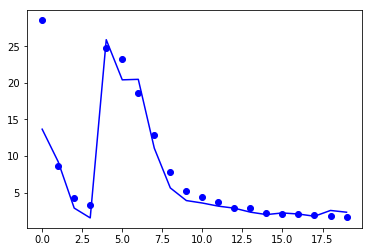

In [134]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [32]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [64]:
def show_wrong_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        if img_gen.label_length - len(l) < 0:
            print(l)
        pred = np.lib.pad(l, ((0, abs(img_gen.label_length - len(l)))),  mode='constant', constant_values=0)
        equal = np.array_equal(pred, y_test[j])
        is_long = is_long_label(y_test[j])
        
        if not equal:
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
            plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0), titles=[u'的'])
    

柳=29839
柳=6075
91656+(82642-(回/46950+8842))
锁=67574
塘*(复/85814-77494-43109)
柳-(65454*(奔/26836-7834))
水=22871
锁=35473
深=44448
((81984+27327)-烧)*奔/43062


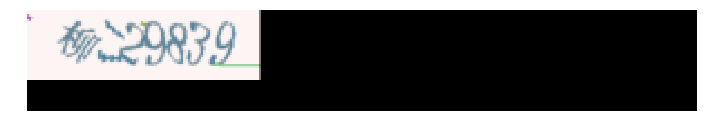

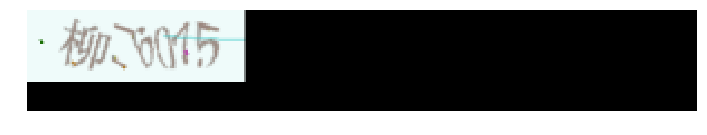

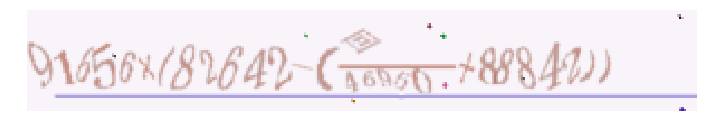

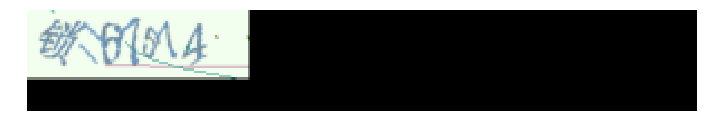

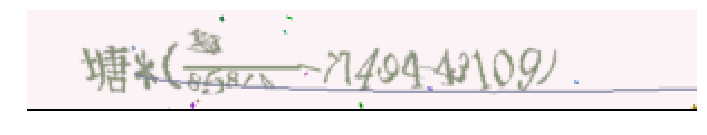

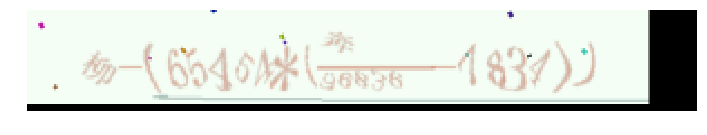

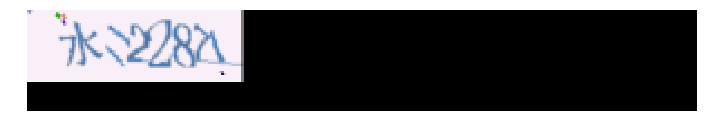

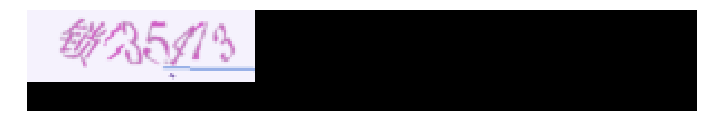

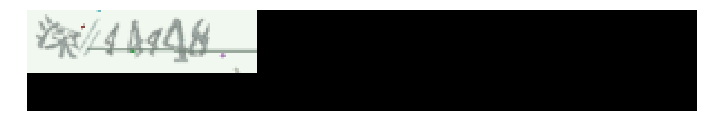

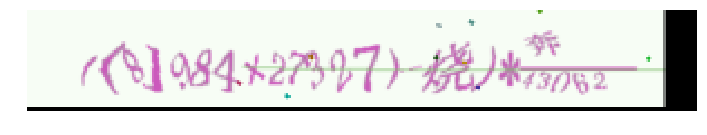

In [70]:
show_result(base_model, 10)

In [60]:
evaluate(base_model)

[ 0  0 21  5  7  7  8 15 13  2 12 14 10  7 13  1  2  7  8  6 10 14  7  1  2  9 11 14 11 10  1]
[ 0 22  5 12  9 13  9 10  3  0  7  6  8  8 12  3 13 10  8 14 15  1  1  4 11  7 11 14  1 12  1]
[ 0 42  5 12  7  9  6  9  4  0 15 12  7  6 11  4 11  6  6  9 10  1  1  2 11  7 13  9  1 12  1]


(0.5555777289962084, 0, 0.5555777289962084)

401-(深+13389)+流/75049(((((((((  602-(深+13389)+流/75049(((((((((
池+((河/32549*59436)+38817((((  池+((河/32549*59436)+38817)(((((
黄=26205((((((((((((((((((((((  黄=26905(((((((((((((((((((((((
[38  3  0  0 13  6  7 12  8  3 13 13  8  7  6 13  1  3 17  5 11 10 13 15  6  1  0  0  0  0  0]
烧+((70162+772107)+上/54790)(((((  烧+((70162+72107)+上/24790)(((((
见=9439(((((((((((((((((((((((  见=39439(((((((((((((((((((((((


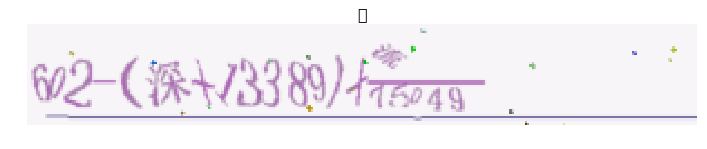

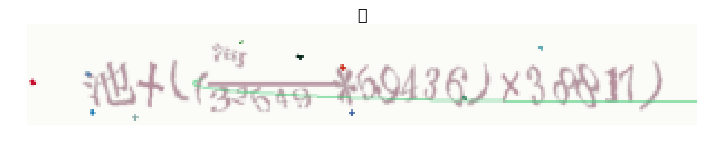

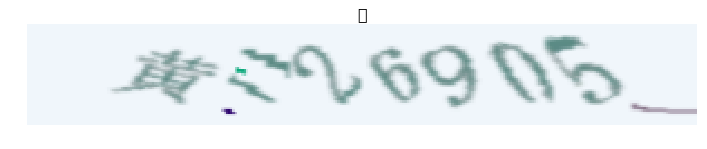

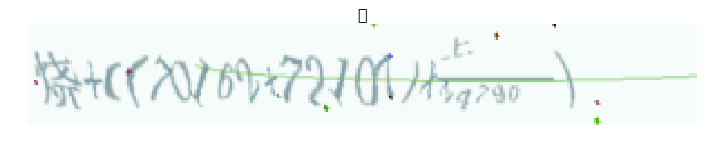

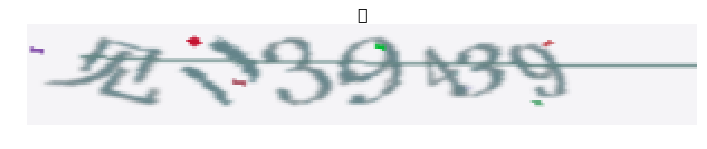

In [65]:
show_wrong_result(base_model, 10)

In [57]:
%ls

all_long_imgs.dat/    emoji.ipynb              redux.ipynb      v16.wgt
all_long_labels.dat/  farm.ipynb               results_ljy.txt  v17.wgt
baid_level2.ipynb     feature_learning.ipynb   results.txt      v18.wgt
baidu_cnn_gru.ipynb   fish.ipynb               rnn.ipynb        v19.wgt
baidu_demo.ipynb      gru.h5                   short_cnn.ipynb  v1.h
baidu.ipynb           l2_first_54.h5           short.ipynb      v1.h5
baidu-m2.ipynb        l2_first_54.wgt          statefarm.ipynb  v1.wgt
baidu_predict.ipynb   l2_first.h5              state_ft.ipynb   v2.wgt
best_1.wgt            level_2_rnn-Copy1.ipynb  state.ipynb      v3.wgt
best_1.wgt0           level_2_rnn.ipynb        test--1-3.png    v4.wgt
best_1.wgt1           linear.ipynb             test--2-3.png    v5.wgt
best_1.wgt2           ljy-02.ipynb             test--3-3.png    v6.wgt
best_1.wgt3           ljy_0.txt                Untitled.ipynb   v7.wgt
best_1.wgt4           ljy_1.txt                utils.py*        v8.wgt
best_

In [54]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 298, 43, 64)   1792        the_input[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 149, 21, 64)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 147, 19, 128)  73856       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')

In [59]:
model.save_weights('xxx.wgt')

In [22]:
model.load_weights('xxx.wgt')

In [ ]:
model